In [1]:
import findspark
findspark.init()
import pyspark
findspark.find()

'C:\\spark-3.5.3-bin-hadoop3'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BooksRecommendations") \
    .master("local[*]") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "1g") \
    .config("spark.executor.extraJavaOptions", "-Xss4m") \
    .config("spark.driver.extraJavaOptions", "-Xss4m") \
    .config("spark.ui.showConsoleProgress", "true") \
    .getOrCreate()
spark.sparkContext.setLogLevel("DEBUG")

In [3]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col


ratings_spark = spark.read.csv("./Ratings.csv", header=True, inferSchema=True).limit(100000)
books_spark = spark.read.csv("./Books.csv", header=True, inferSchema=True)
users_spark = spark.read.csv("./Users.csv", header=True, inferSchema=True)

isbn_indexer = StringIndexer(inputCol="ISBN", outputCol="ISBNIndex").fit(ratings_spark)
indexed_ratings = isbn_indexer.transform(ratings_spark)

avg_age = users_spark.select("Age").na.drop().agg({"Age": "avg"}).collect()[0][0]
users_spark = users_spark.withColumn(
    "Age",
    col("Age").cast("float")
).na.fill({"Age": avg_age})

location_indexer = StringIndexer(inputCol="Location", outputCol="LocationIndex").fit(users_spark)
users_spark = location_indexer.transform(users_spark)

(training, test) = indexed_ratings.randomSplit([0.8, 0.2], seed=1234)

training = training.dropna(subset=["User-ID", "ISBNIndex", "Book-Rating"])
test = test.dropna(subset=["User-ID", "ISBNIndex", "Book-Rating"])




In [ ]:
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Book-Rating",
    predictionCol="prediction"
)

als = ALS(
    userCol="User-ID",
    itemCol="ISBNIndex",
    ratingCol="Book-Rating",
    coldStartStrategy="drop"
)

paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [30, 40, 50]) \
    .addGrid(als.regParam, [1, 2, 3]) \
    .addGrid(als.maxIter, [20, 30]) \
    .build()

crossval = CrossValidator(
    estimator=als,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = crossval.fit(training)

best_model = cv_model.bestModel

best_rank = best_model.rank
best_regParam = best_model._java_obj.parent().getRegParam()
best_maxIter = best_model._java_obj.parent().getMaxIter()

print(f"Best rank: {best_rank}")
print(f"Best regParam: {best_regParam}")
print(f"Best maxIter: {best_maxIter}")

predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)
print(f"Test RMSE for the best model: {rmse}")

Best rank: 40
Best regParam: 2.0
Best maxIter: 30
Test RMSE for the best model: 4.4868511765887895


In [5]:

from pyspark.sql.functions import explode, col
from pyspark.ml.feature import IndexToString

isbn_converter = IndexToString(inputCol="ISBNIndex", outputCol="ISBN", labels=isbn_indexer.labels)

all_user_recommendations = best_model.recommendForAllUsers(10)

flat_recommendations = all_user_recommendations \
    .withColumn("recommendations", explode(col("recommendations"))) \
    .select(
        col("recommendations.ISBNIndex").alias("ISBNIndex"),
        col("recommendations.rating").alias("predicted_rating")
    )

flat_recommendations = isbn_converter.transform(flat_recommendations)

average_ratings = flat_recommendations \
    .groupBy("ISBN") \
    .avg("predicted_rating") \
    .withColumnRenamed("avg(predicted_rating)", "average_predicted_rating")

top_10_overall = average_ratings.orderBy(col("average_predicted_rating").desc()).limit(10)

print("Top-10 Recommendations for all users:")
top_10_overall.show()

print()

top_10_with_details = top_10_overall.join(
    books_spark,
    on="ISBN",
    how="left"
)

print("Detailed Top-10 Recommendations for all users:")
top_10_with_details.select("Book-Title", "Book-Author", "average_predicted_rating").orderBy(col("average_predicted_rating").desc()).show()


Top-10 Recommendations for all users:
+----------+------------------------+
|      ISBN|average_predicted_rating|
+----------+------------------------+
|0061009482|       8.763969421386719|
|0515103969|       8.685998916625977|
|1878399705|         8.5183687210083|
|3453879236|       8.493897676467896|
|0819830992|       8.135774612426758|
|9023470923|       8.042176961898804|
|0486270718|       8.021389770507813|
|0312319142|       8.012151718139648|
|0312319517|       8.012151718139648|
|0316591122|       8.012151718139648|
+----------+------------------------+


Detailed Top-10 Recommendations for all users:
+--------------------+-----------------+------------------------+
|          Book-Title|      Book-Author|average_predicted_rating|
+--------------------+-----------------+------------------------+
|The Sacrifice of ...|      Naomi Ragen|       8.763969421386719|
|      The Endearment|  LaVyrle Spencer|       8.685998916625977|
|Maryland Lighthou...|  F. Ross Holland|         8.

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler

user_features = ratings_spark.groupBy("User-ID").agg(
    F.count("ISBN").alias("num_ratings"),
    F.avg("Book-Rating").alias("avg_rating"),
).join(users_spark, on="User-ID", how="inner")

assembler = VectorAssembler(inputCols=["num_ratings", "avg_rating", "LocationIndex", "Age"], outputCol="raw_features")
data_with_features = assembler.transform(user_features)

scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=False)
data_with_features = scaler.fit(data_with_features).transform(data_with_features)

kmeans = KMeans(k=3, seed=1234, featuresCol="features", predictionCol="cluster")
clustering_model = kmeans.fit(data_with_features)

user_clusters = clustering_model.transform(data_with_features)

user_clusters.select("User-ID", "num_ratings", "avg_rating", "Age", "Location", "cluster").show()

+-------+-----------+------------------+---------+--------------------+-------+
|User-ID|num_ratings|        avg_rating|      Age|            Location|cluster|
+-------+-----------+------------------+---------+--------------------+-------+
|      2|          1|               0.0|     18.0|stockton, califor...|      0|
|      7|          1|               0.0|34.751835| washington, dc, usa|      0|
|      8|         18|2.1666666666666665|34.751835|timmins, ontario,...|      0|
|      9|          3|               2.0|34.751835|germantown, tenne...|      0|
|     10|          2|               3.0|     26.0|albacete, wiscons...|      0|
|     12|          1|              10.0|34.751835|fort bragg, calif...|      1|
|     14|          4|               4.0|34.751835|mediapolis, iowa,...|      0|
|     16|          2|               4.5|34.751835|albuquerque, new ...|      1|
|     17|          7|               3.0|34.751835|chesapeake, virgi...|      0|
|     19|          1|               7.0|

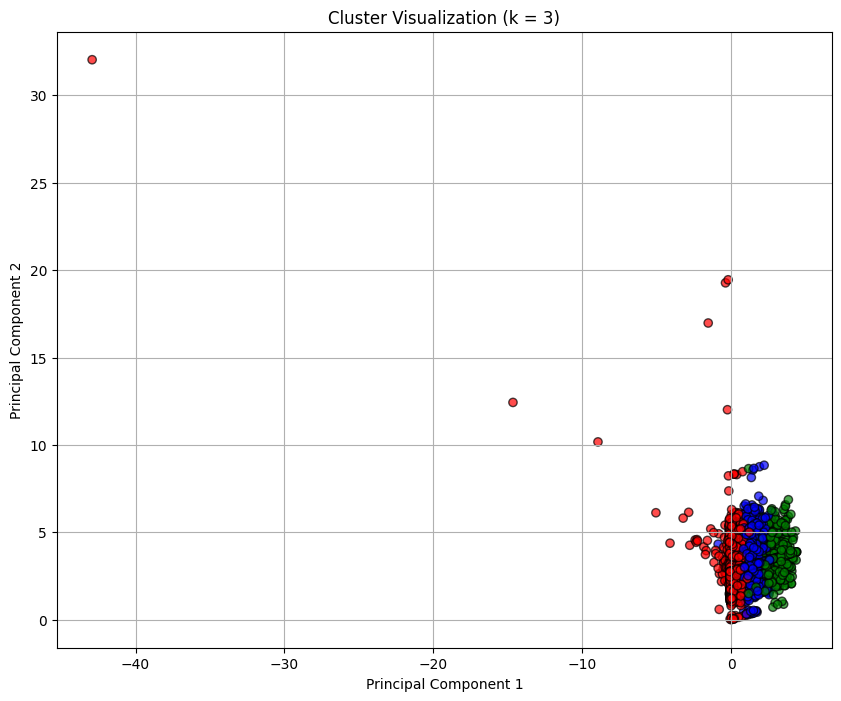

In [22]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import numpy as np

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(user_clusters)
pca_data = pca_model.transform(user_clusters)

pca_points = pca_data.select("pca_features", "cluster").rdd.map(
    lambda row: (row["pca_features"][0], row["pca_features"][1], row["cluster"])
).collect()

x = [point[0] for point in pca_points]
y = [point[1] for point in pca_points]
labels = [point[2] for point in pca_points]

plt.figure(figsize=(10, 8))
colors = np.array(['red', 'blue', 'green'])
plt.scatter(x, y, c=colors[labels], alpha=0.7, edgecolors='k')
plt.title(f"Cluster Visualization (k = {clustering_model.getK()})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [23]:
cluster0users = user_clusters.filter(col('cluster') == 0)
cluster1users = user_clusters.filter(col('cluster') == 1)
cluster2users = user_clusters.filter(col('cluster') == 2)

cluster0ratings = training.join(cluster0users, on="USER-ID", how='inner')
cluster1ratings = training.join(cluster1users, on="USER-ID", how='inner')
cluster2ratings = training.join(cluster2users, on="USER-ID", how='inner')

als.setRank(best_rank)
als.setRegParam(best_regParam)
als.setMaxIter(best_maxIter)

model0 = als.fit(cluster0ratings)
model1 = als.fit(cluster1ratings)
model2 = als.fit(cluster2ratings)

In [49]:
from pyspark.sql.window import Window

test_data = indexed_ratings.join(data_with_features, on="USER-ID", how="inner") 

cluster_predictions = clustering_model.transform(test_data)

cluster_predictions0 = predictions.filter(col('cluster') == 0)
cluster_predictions1 = predictions.filter(col('cluster') == 1)
cluster_predictions2 = predictions.filter(col('cluster') == 2)

cluster_0_table = model0.transform(cluster_predictions0).groupBy("ISBN").agg(F.avg("prediction").alias("avg_predicted_rating"))
cluster_1_table = model1.transform(cluster_predictions1).groupBy("ISBN").agg(F.avg("prediction").alias("avg_predicted_rating"))
cluster_2_table = model2.transform(cluster_predictions2).groupBy("ISBN").agg(F.avg("prediction").alias("avg_predicted_rating"))

print("Top 10 for cluster 0")
cluster_0_table.join(books_spark, on="ISBN", how="left").select("ISBN", "Book-Title", "Book-Author", "Publisher", "avg_predicted_rating").orderBy(col("avg_predicted_rating").desc()).limit(10).show()

print("Top 10 for cluster 1")
cluster_1_table.join(books_spark, on="ISBN", how="left").select("ISBN", "Book-Title", "Book-Author", "Publisher", "avg_predicted_rating").orderBy(col("avg_predicted_rating").desc()).limit(10).show()

print("Top 10 for cluster 2")
cluster_2_table.join(books_spark, on="ISBN", how="left").select("ISBN", "Book-Title", "Book-Author", "Publisher", "avg_predicted_rating").orderBy(col("avg_predicted_rating").desc()).limit(10).show()



Top 10 for cluster 0
+-----------+--------------------+----------------+--------------------+--------------------+
|       ISBN|          Book-Title|     Book-Author|           Publisher|avg_predicted_rating|
+-----------+--------------------+----------------+--------------------+--------------------+
| 1221229631|                NULL|            NULL|                NULL|   8.000000953674316|
| 0749397403|                NULL|            NULL|                NULL|   7.999999523162842|
|2.253000043|                NULL|            NULL|                NULL|   7.597014427185059|
| 0595149782|Runaways: America...|Maryanne Raphael|     Backinprint.com|   7.171573638916016|
| 0416052029|The Dream Catcher...|   Monica Hughes|Methuen Publishin...|   7.171573162078857|
| 0070399042|Sweet Life: Adven...|   Barry Manilow|         McGraw-Hill|   7.171572208404541|
| 0394223632|                NULL|            NULL|                NULL|    7.16209077835083|
| 0563551437|The Nation's Favo...|Griff